In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pathlib import Path

ASSIGNMENT_PATH = Path('/content/drive/My Drive/jobe')

# Liberaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.datasets import cifar10
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

## Load Data

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


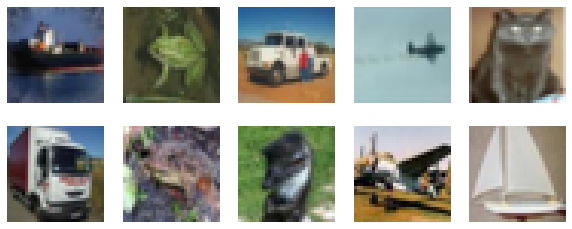

In [4]:
num_classes = 10
label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(x_train)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x_train[i:i+1][0])
        
# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Evaluation functions

In [ ]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['acc']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def draw_confusion_matrix(model, classes=None, normalize=True, title=None, cmap=plt.cm.Blues):
    y_pred = model.predict(x_test)
    y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
    y_true = [np.argmax(y_test[i]) for i in range(len(y_test))]
    scores = model.evaluate(x_test, y_test, verbose = 0)
    print('Test accuracy:', scores[1])

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion Matrix = \n')

    if classes is None:
        classes = label_name

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    print('\n')
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

def plot_most_error(model, n = 10):
  '''
  n : number of samples with most error in prediction
  '''
  test_proba = model.predict_proba(x_test)
  true_proba = [test_proba[i][np.argmax(y_test[i])] for i in range(len(y_test))]
  sorted_error_proba = np.argsort(true_proba)
  y_pred = model.predict(x_test)

  for i in range(n):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(x_test[sorted_error_proba[i]])
    print('true label: ',label_name[np.argmax(y_test[sorted_error_proba[i]])])
    print('predict label: ',label_name[np.argmax(y_pred[sorted_error_proba[i]])])
    height = test_proba[sorted_error_proba[i]]
    bars = label_name
    y_pos = np.arange(len(bars))
    plt.subplot(1,2,2)
    plt.barh(y_pos, height)
    plt.yticks(y_pos, bars)
    plt.show()
    print('################################################################################################################')

## Base Model

In [15]:
def base_model():

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
                metrics=['accuracy'])
  return model

batch_size = 64
epochs = 100

# Create the baseline model
first_model = base_model()
first_model.summary()
# Train model
first_history = first_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

first_model.save(str(ASSIGNMENT_PATH / 'cifar_base.h5'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 128)        

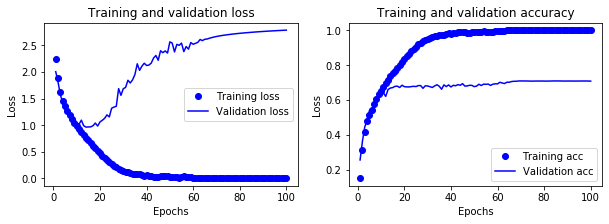

Test accuracy: 0.708
Confusion Matrix = 





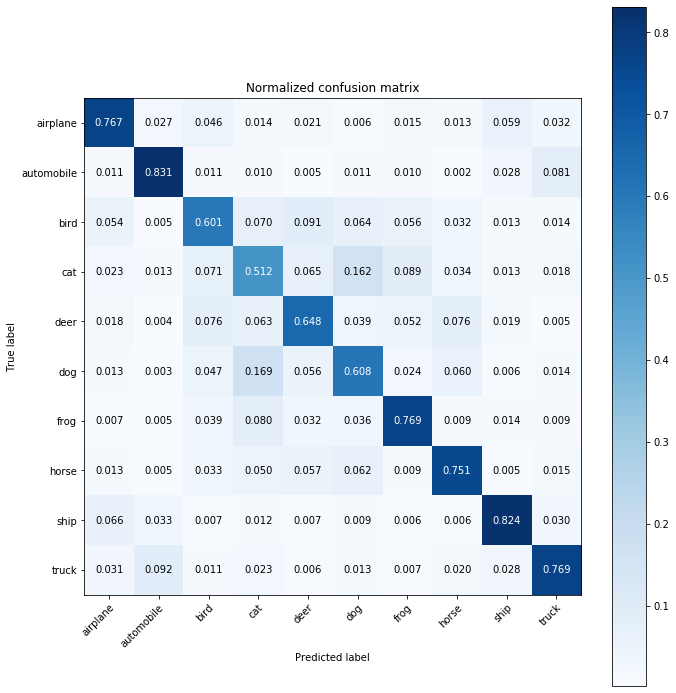

true label:  bird
predict label:  airplane


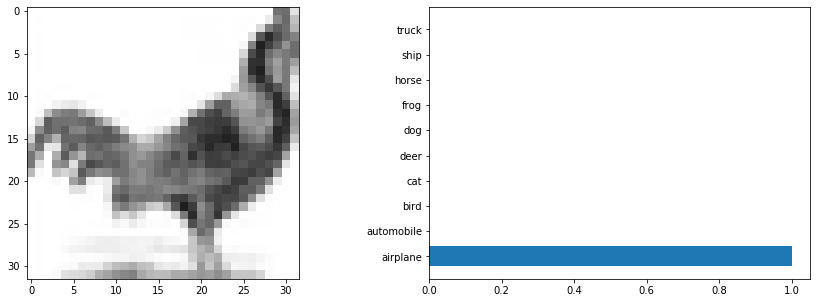

################################################################################################################
true label:  automobile
predict label:  cat


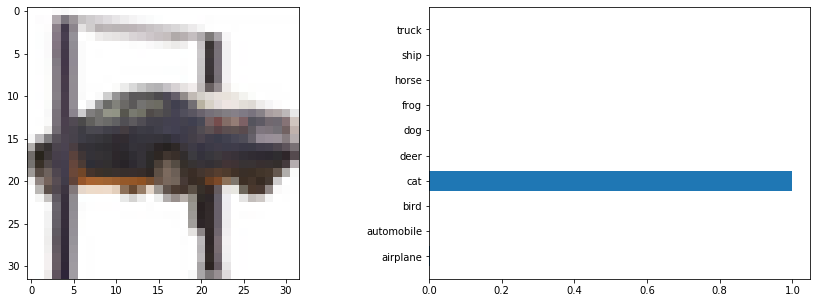

################################################################################################################
true label:  ship
predict label:  dog


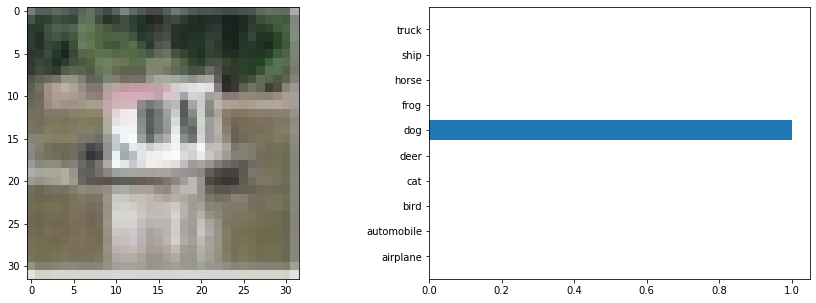

################################################################################################################
true label:  automobile
predict label:  dog


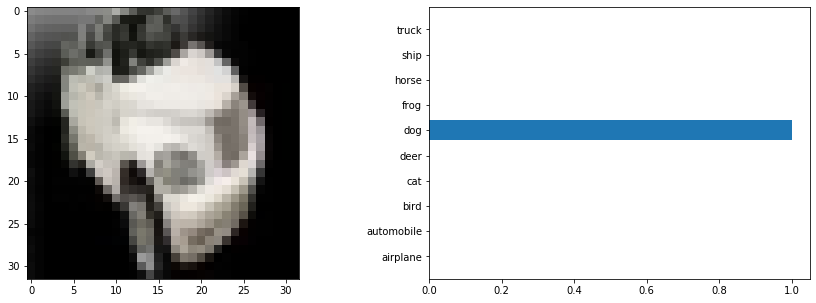

################################################################################################################
true label:  ship
predict label:  airplane


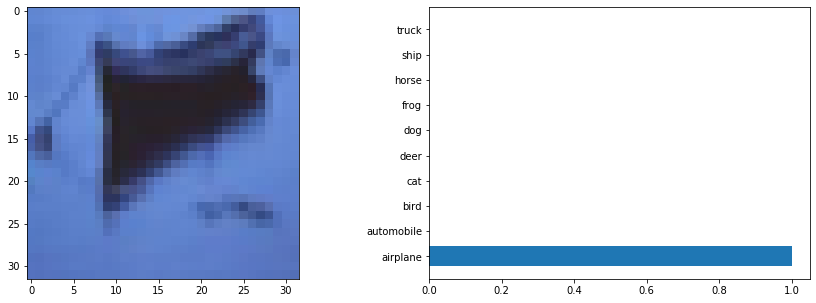

################################################################################################################
true label:  truck
predict label:  automobile


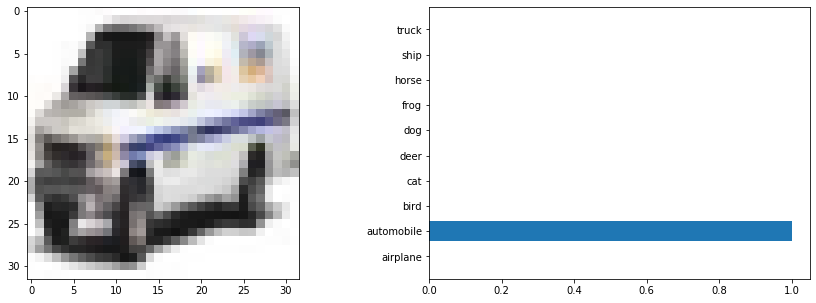

################################################################################################################
true label:  bird
predict label:  dog


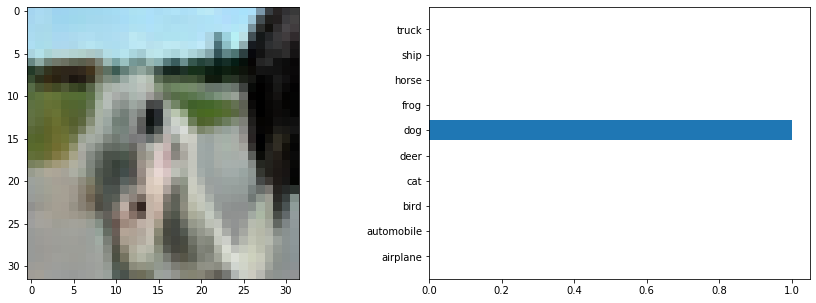

################################################################################################################
true label:  airplane
predict label:  ship


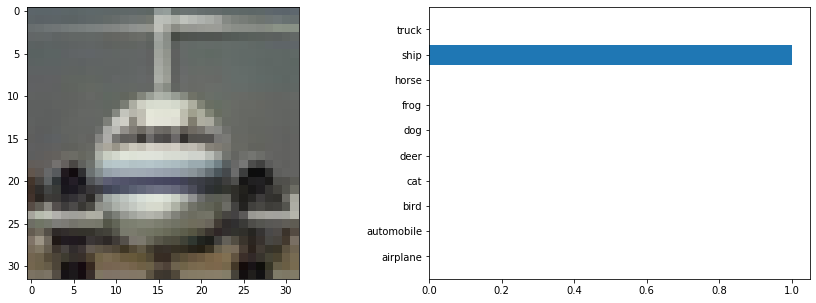

################################################################################################################
true label:  bird
predict label:  deer


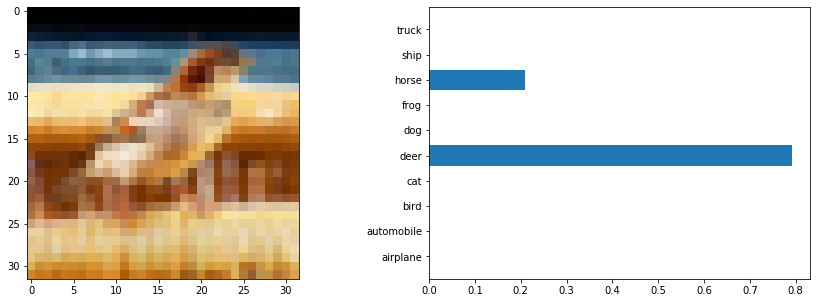

################################################################################################################
true label:  airplane
predict label:  ship


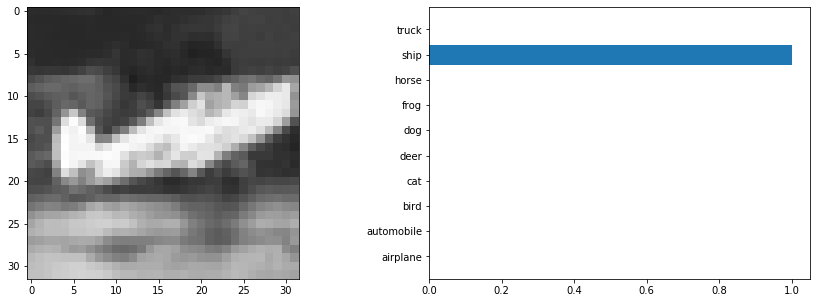

################################################################################################################


In [16]:
visualize_loss_and_acc(first_history)
draw_confusion_matrix(first_model)
plot_most_error(first_model,10)

## Enhanced Models

In [ ]:
def improve_model():

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
                metrics=['accuracy'])
  return model


In [11]:
impv_model = improve_model()
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=64)
steps = int(x_train.shape[0] / 64)

imp_history = impv_model.fit_generator(it_train, steps_per_epoch=steps, epochs=400, validation_data=(x_test, y_test), verbose = 2)
impv_model.save(str(ASSIGNMENT_PATH / 'cifar_impv.h5'))

Epoch 1/400
 - 35s - loss: 2.0402 - acc: 0.3220 - val_loss: 1.4992 - val_acc: 0.4556
Epoch 2/400
 - 33s - loss: 1.5506 - acc: 0.4324 - val_loss: 1.3421 - val_acc: 0.5092
Epoch 3/400
 - 33s - loss: 1.4122 - acc: 0.4841 - val_loss: 1.3003 - val_acc: 0.5259
Epoch 4/400
 - 33s - loss: 1.3206 - acc: 0.5238 - val_loss: 1.2967 - val_acc: 0.5267
Epoch 5/400
 - 33s - loss: 1.2447 - acc: 0.5518 - val_loss: 1.2302 - val_acc: 0.5545
Epoch 6/400
 - 33s - loss: 1.1862 - acc: 0.5775 - val_loss: 1.2181 - val_acc: 0.5612
Epoch 7/400
 - 33s - loss: 1.1383 - acc: 0.5934 - val_loss: 1.2343 - val_acc: 0.5617
Epoch 8/400
 - 33s - loss: 1.0946 - acc: 0.6088 - val_loss: 1.1530 - val_acc: 0.5925
Epoch 9/400
 - 33s - loss: 1.0593 - acc: 0.6232 - val_loss: 1.0477 - val_acc: 0.6303
Epoch 10/400
 - 33s - loss: 1.0169 - acc: 0.6384 - val_loss: 0.9832 - val_acc: 0.6456
Epoch 11/400
 - 33s - loss: 0.9907 - acc: 0.6507 - val_loss: 0.9265 - val_acc: 0.6709
Epoch 12/400
 - 33s - loss: 0.9573 - acc: 0.6612 - val_loss: 0.

In [6]:
im = load_model(str(ASSIGNMENT_PATH / 'cifar_impv.h5'))
im.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)       

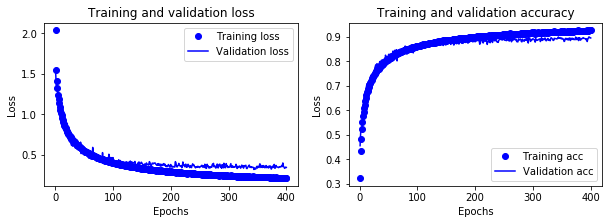

Test accuracy: 0.8952
Confusion Matrix = 





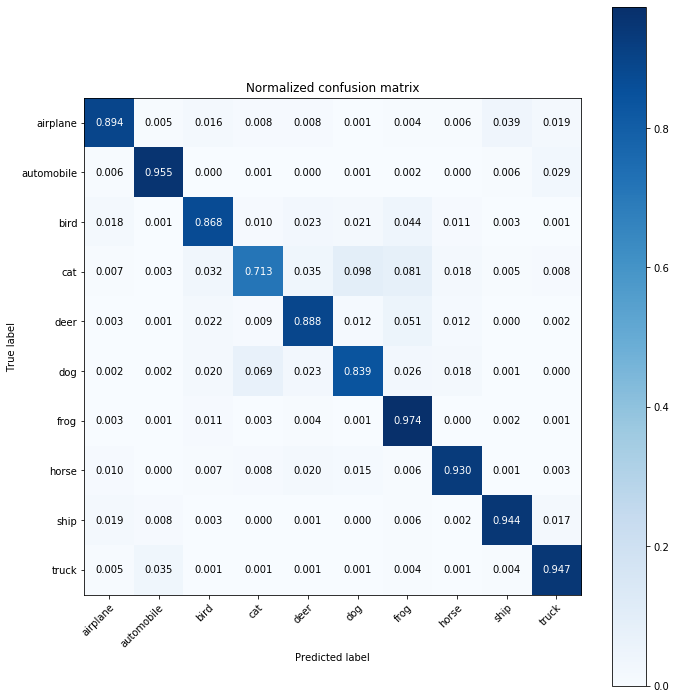

true label:  cat
predict label:  frog


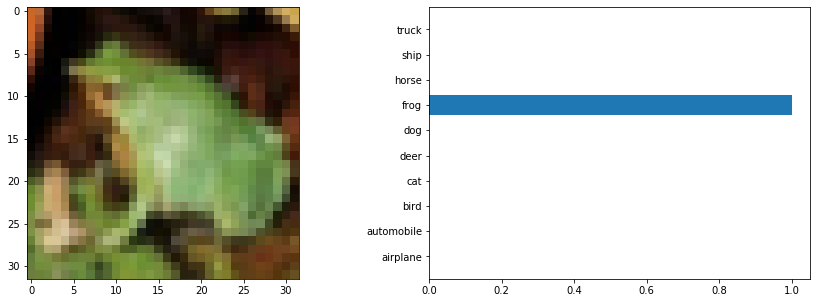

################################################################################################################
true label:  cat
predict label:  airplane


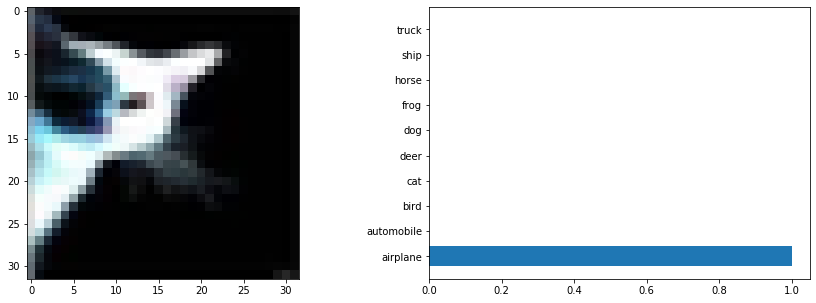

################################################################################################################
true label:  cat
predict label:  frog


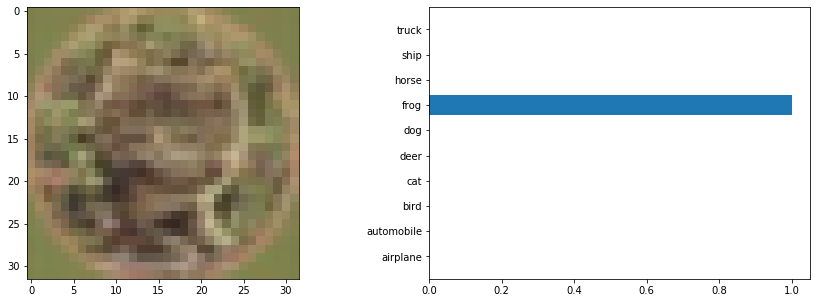

################################################################################################################
true label:  airplane
predict label:  ship


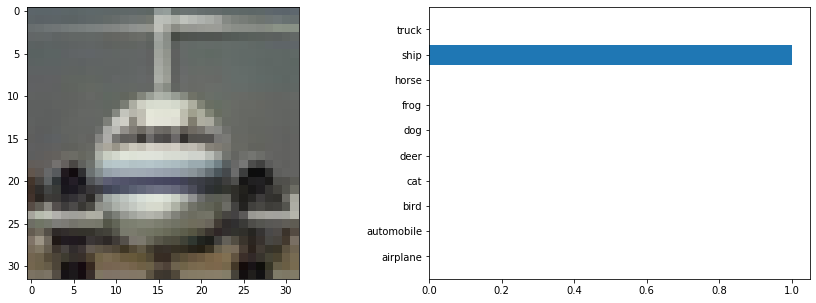

################################################################################################################
true label:  automobile
predict label:  truck


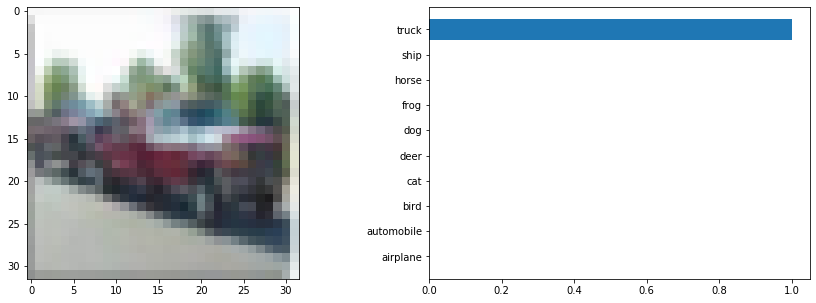

################################################################################################################
true label:  dog
predict label:  bird


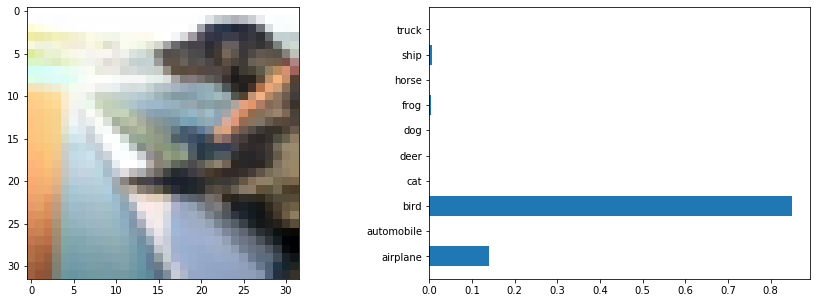

################################################################################################################
true label:  airplane
predict label:  automobile


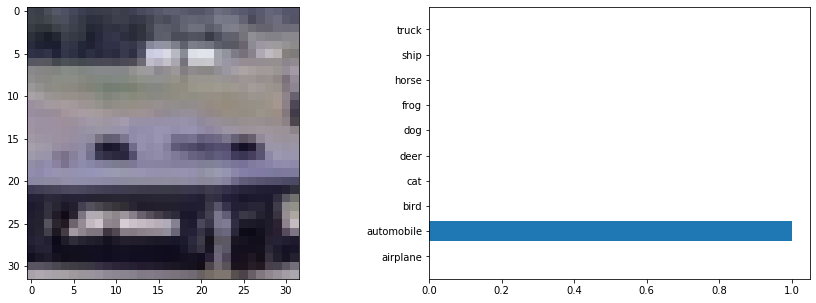

################################################################################################################
true label:  dog
predict label:  airplane


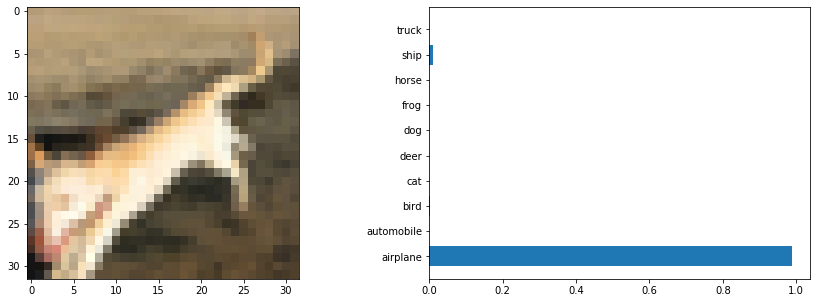

################################################################################################################
true label:  dog
predict label:  deer


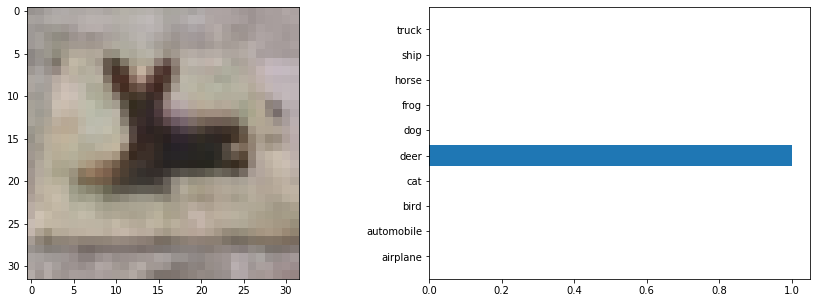

################################################################################################################
true label:  cat
predict label:  horse


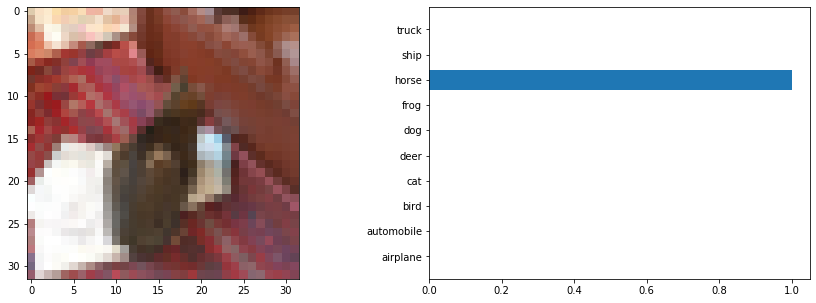

################################################################################################################


In [14]:
visualize_loss_and_acc(imp_history)
draw_confusion_matrix(impv_model)
plot_most_error(impv_model,10)

In [ ]:
def improve2_model():

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
                metrics=['accuracy'])
  return model

# Create the baseline model
impv2_model = improve2_model()

# create data generator
datagen2 = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train2 = datagen2.flow(x_train, y_train, batch_size=64)
# fit model
steps = int(x_train.shape[0] / 64)
imp2_history = impv2_model.fit_generator(it_train2, steps_per_epoch=steps, epochs=400, validation_data=(x_test, y_test), verbose = 2)
impv_model.save(str(ASSIGNMENT_PATH / 'cifar_impv2.h5'))

In [ ]:
visualize_loss_and_acc(imp2_history)
draw_confusion_matrix(impv2_model)
plot_most_error(impv2_model,10)